In [1]:
import gym
import random
#from collections import deque
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import clear_output
import time
import warnings
warnings.filterwarnings('ignore')
import random
import GPy
import GPyOpt
import numpy as np
import pandas as pd
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
import math
from tensorflow.keras import Sequential
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.activations import relu, linear
from numpy.random import multivariate_normal
import time
env = gym.make('LunarLander-v2')
env.seed(0)
np.random.seed(0)

In [2]:
'''
    Reference : https://github.com/shivaverma/OpenAIGym/blob/master/lunar-lander/discrete/lunar_lander.py
'''
class DQN:
    """ Implementation of deep q learning algorithm """
    def __init__(self, action_space, state_space, lr=0.001, gamma=0.99):
        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [3]:
def train_dqn(env, steps, lr, gamma=None, episodes=50):
    agent = DQN(env.action_space.n, env.observation_space.shape[0], lr, gamma)
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        max_steps = steps
        score = 0
        for i in range(max_steps):
            action = agent.act(state)
            #env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("score: {}".format(score))
                break
            if score > 200:
                print('\n Task Completed! \n')
                break
    return agent

In [4]:
def test_policy(env, model):
    obs = env.reset()
    obs = np.reshape(obs, (1, 8))
    dones=False
    total_reward=0
    global best_reward
    while not dones:
        action = model.act(obs)
        obs, rewards, dones, info = env.step(action)
        obs = np.reshape(obs, (1, 8))
        #env.render()
        total_reward+=rewards
    if total_reward > best_reward:
        best_reward = total_reward
        #print("Inside save!")
        #model.save("deepq_model_lunar_lander")
    return total_reward

In [5]:
env = gym.make('LunarLander-v2')
best_reward = -math.inf

def f2d(gamma, lr, live=False, best_samples=None, episodes=10):
    env.reset()
    lr = lr
    gamma = gamma
    print(lr, gamma)
    max_steps = 1000
    #model = train_model(env, max_steps, gamma[0], lr[0], train_freq=5, batch_size=32)
    res = train_dqn(env, max_steps, lr, gamma, episodes)
    test_reward = test_policy(env, res)
    print(test_reward)
    return test_reward

def f(lr, episodes=50):
    env.reset()
    lr = lr
    gamma = 0.99
    print(lr, gamma)
    max_steps = 10000
    #model = train_model(env, max_steps, gamma[0], lr[0], train_freq=5, batch_size=32)
    res = train_dqn(env, max_steps, lr, gamma, episodes=episodes)
    test_reward = test_policy(env, res)
    print(test_reward)
    return test_reward

In [6]:
lr_params = np.linspace(0.01,0.5).reshape(-1, 1)
#gamma_params = np.array([0.1, 0.25, 0.5, 0.75, 1 ]).reshape(-1, 1)
gamma_params = np.linspace(0.1,0.99).reshape(-1, 1)
#gamma_params = np.array([0.1, 0.25 ]).reshape(-1, 1)

'''# LR Init
X = lr_params
X_l = np.random.choice(lr_params.flatten())
#X_g = np.random.choice(gamma_params.flatten())
Y_l = np.array([f(lr=0.001, episodes=1)])[: np.newaxis]
X_l = np.array([X_l])[: np.newaxis]'''
'''
# Gamma Init
X_g = np.random.choice(gamma_params.flatten())
#Y_g = np.array([f(gamma=X_g)]).reshape(-1, 1)
X_g = np.array([X_g]).reshape(-1,1)
Y_g = f(lr=lr, gamma=X_g[0][0])'''
#X_p = np.random.choice(lr_params.flatten())
#Y_p = f(X_p)
#X_p = np.asarray(X_p).reshape(-1, 1)

#X_p = np.vstack((np.random.choice(lr_params.flatten()), np.random.choice(gamma_params.flatten()))).T
#Y_p = np.asarray(Y_p).reshape(-1, 1)
X = np.hstack((gamma_params, lr_params))
X_p = np.vstack((np.random.choice(gamma_params.flatten()), np.random.choice(lr_params.flatten()))).T
Y_p = f2d(gamma=X[0,0], lr=X[0,1])
Y_p = np.asarray(Y_p).reshape(-1, 1)

0.01 0.1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
score: -261.9140450934039
score: -44.601226014523974
score: -478.221048884349
score: -285.790250248904
score: -122.38917129441167
score: -297.9174388979129
score: -268.2274990988335
score: -250.34841635174902
score: -159.82371242373313
score: -362.2484168444744
-435.80673024306157


In [7]:
'''
    GP Settings for BayOpt
'''
dims = X.shape[1]
mean_function_k = GPy.mappings.Constant(dims, 1, value=-600)
#mean_function_k = GPy.mappings.Constant(dims, 1, value=0)
mean_function_y = GPy.mappings.Linear(dims,1)
mean_function_y.A = 1000
#mf_additive = GPy.mappings.Additive(mean_function_y, mean_function_k)

kernel = GPy.kern.RBF(dims,variance=600,lengthscale=0.1)

'''k1 = GPy.kern.RBF(input_dim=dims,variance=600, lengthscale=0.1)
k2 = GPy.kern.Matern32(input_dim=1,variance=600, lengthscale=0.1)
k3 = GPy.kern.Matern52(input_dim=1,variance=600, lengthscale=0.1)
kernel =  GPy.kern.Add([k1.copy(),k2.copy(),k3.copy()])'''

#kernel = GPy.kern.RBF(1,variance=600,lengthscale=0.1)

#m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
#gpr = GaussianProcessRegressor(kernel=m52)
#=GPy.mappings.Constant(1, 1, value=0)
#gpr = GPy.models.GPRegression(X_p,Y_p,kernel=kernel)#,mean_function=mean_function_k)

'k1 = GPy.kern.RBF(input_dim=dims,variance=600, lengthscale=0.1)\nk2 = GPy.kern.Matern32(input_dim=1,variance=600, lengthscale=0.1)\nk3 = GPy.kern.Matern52(input_dim=1,variance=600, lengthscale=0.1)\nkernel =  GPy.kern.Add([k1.copy(),k2.copy(),k3.copy()])'

In [10]:
%run UtilOpt.ipynb

[[0.1 ]
 [0.01]]
0.01 0.1
score: -134.84354940465744
score: -145.62225305207824
score: -509.2512298612736
score: -436.756239733778
score: -454.05314995371333
score: -128.19852776976745
score: -198.43752489453595
score: -263.8941259716123
score: -187.58554891542792
score: -197.49777635374681
-872.6385490871303
[[0.3483424]
 [0.5      ]]
0.5 0.3483423992816446
score: -275.690043235745
score: -185.88366140828728
score: -314.334131758327
score: -116.78723343537625
score: -196.93024003439382
score: -807.7899328544605
score: -182.07144866481036
score: -124.38665861369806
score: -43.834965870403245
score: -101.82751937038302
-463.5163152316158
[[0.65800908]
 [0.01      ]]
0.01 0.6580090848000949
score: -134.38070919573735
score: -128.20711296541364
score: -138.97142266818634
score: -249.93522798105025
score: -435.8089023792467
score: -91.55860354925922
score: -126.21494715045714
score: -126.49791461001074
score: -82.01378175802526
score: -18.51346476582694
-270.7345487544083
[[0.99      ]
 [0

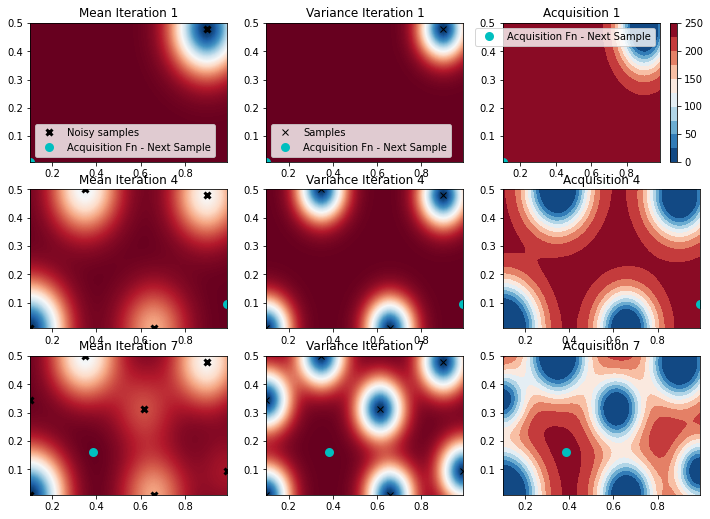

In [11]:
%%time
n_iter = 8
#lr = 0.4
plt.figure(figsize=(12, n_iter * 3))
# EI 1D hyperparameter Optimization over Lr
'''x_opt, f_opt = bayOptEI(n_iter=n_iter, opt=False, kernel=kernel, mf=mean_function_k, X=lr_params, \
                        X_init=X_p, Y_init=Y_p, f=f, lr=lr , plotPlots=True)'''
# EI 1D hyperparameter Optimization over Gamma, Lr
x_opt, f_opt = bayOptEI_2d(n_iter=n_iter, kernel=kernel, X= X,bounds=np.array([[0.1, 0.99], [0.01, 0.5]]), \
                        X_init=X_p, Y_init=Y_p, f=f2d, lr=None , plotPlots=True)
